# Problem Statement:
    
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, 
Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. 
Store sales are influenced by many factors, including promotions, competition, school and state holidays, 
seasonality, and locality.

 

With thousands of individual managers predicting sales based on their unique circumstances, 
the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann 
stores. The task is to forecast the "Sales" column. Note that some stores in the dataset were temporarily
closed for refurbishment.

# Data definition

Most of the fields are self-explanatory. The following are descriptions for important variables.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Please keep the following question in mind while forecasting sales:


Is the sales data non-stationary?

If so, how do you find it and correct for it?


Is the data co-integrated?

Which variables are co-integrated and how do you find it?

What is the impact of the number of customers on sales? How do you measure it?

What is the impact of promo and promo2 variables on sales? How do you measure it?

Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE.

Let’s say promo2 is decided based on the sales in the previous day. How do you measure the impact of promo2 on sales and the impact of sales on promo2?

Which independent variables have long term impact on sales and which have short term impact? Describe the approach in detail.


# Please follow these steps while you explore the data and build the model.

 

Find outliers at 99th percentile and remove them.

Standardize the sales and number of customers variables before modelling.

Test the data for non-stationarity using ADF test for sales

Determine if the data is stationary

If stationary then specify Vector Autoregression Model in Levels

If non-stationary then specify the model in differences

Make sales, promo2 and any other variables you think as dependent variables.

Check for cointegration using Johansen test. 

Find out Impulse Response Function to answer questions Q3- to Q7. 

Predict sales for the next 6 weeks.

In [41]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [42]:
# define helper fuctions

# remove outliers xx percentile
def remove_outliers(df, column, percentile = 0.99):
    thresh = df[column].quantile(percentile)
    return df[df[column] <= thresh]

# test if stationary
def test_stationary(df, column):
    result = adfuller(df[column], autolag = 'AIC')
    return result[0] < result[4]['5%']

def granger_test(df, X, Y, lags = 1):
    result = grangercausalitytests(df[[Y, X]], lags)
    return result.get(1)[0].get('ssr_ftest')[1]

# seasonal decompose, additive/multiplicative
def decompose(df, column, add_mult = 'additive', freq = 300):
    res = seasonal_decompose(df[column], model = add_mult, period = freq, extrapolate_trend='freq')
    return res

def find_season(df, column, fmax = 300):
    residuals = []
    for i in range(2, fmax):
        result = decompose(df, column, freq = i)
        residuals.append(abs(result.resid.mean()))
    return np.array(residuals).argmin()+2

def return_dummies(df, column, pref = 'day'):
    return pd.get_dummies(df, columns = [column], prefix = pref)

def return_storedata(df, store_id = 1, only_open = 1):
    return df.query(f'Store == {store_id} and Open == {only_open}')

def standardize_series(df, column):
    mean = df[column].mean()
    stdev = df[column].std()
    temp = (df[column] - mean)/stdev
    return mean, stdev, temp

def destandardize_series(series, mean, stdev):
    return stdev*series+mean

def calculate_mpe(true, predicted):
    MPE=np.mean((true-predicted)/true)
    return MPE
    
def calculate_mape(true, predicted):
    MAPE=np.mean(abs((true-predicted)/true))
    return MAPE

def difference_timeseries(series, dropnan = True):
    if dropnan:
        return series.diff().dropna()
    else:
        return series.diff()
    
def dedifference_timeseries(original, diff_series):
    return diff_series.cumsum() + original[-1]

In [125]:
train = 'data/train.csv'

In [126]:
#read the data
data_df = pd.read_csv(train, encoding="ISO-8859-1", low_memory=False)

###  Stationary timeseries VARMAX model

In [44]:
# choose a store
store_id = 8

In [45]:
# extract the data for "store_id", choose only data on open days
store_df = data_df.query(f'Store == {store_id} and Open == 1')

In [46]:
# sanity check
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
7,8,5,2015-07-31,8492,833,1,1,0,1
1122,8,4,2015-07-30,8420,882,1,1,0,1
2237,8,3,2015-07-29,7029,698,1,1,0,1
3352,8,2,2015-07-28,6717,695,1,1,0,1
4467,8,1,2015-07-27,8739,841,1,1,0,1


In [47]:
store_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1009412,8,1,2013-01-07,7416,802,1,1,0,0
1011642,8,6,2013-01-05,2337,312,1,0,0,0
1012757,8,5,2013-01-04,4059,517,1,0,0,1
1013872,8,4,2013-01-03,4842,662,1,0,0,1
1014987,8,3,2013-01-02,5419,698,1,0,0,1


In [48]:
# reverse the order...
# data should run from past to present ...
store_df = store_df.iloc[::-1]

In [49]:
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1014987,8,3,2013-01-02,5419,698,1,0,0,1
1013872,8,4,2013-01-03,4842,662,1,0,0,1
1012757,8,5,2013-01-04,4059,517,1,0,0,1
1011642,8,6,2013-01-05,2337,312,1,0,0,0
1009412,8,1,2013-01-07,7416,802,1,1,0,0


In [50]:
# reset index
store_df = store_df.reset_index(drop=True)

In [51]:
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,8,3,2013-01-02,5419,698,1,0,0,1
1,8,4,2013-01-03,4842,662,1,0,0,1
2,8,5,2013-01-04,4059,517,1,0,0,1
3,8,6,2013-01-05,2337,312,1,0,0,0
4,8,1,2013-01-07,7416,802,1,1,0,0


In [52]:
# check for missing values
store_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

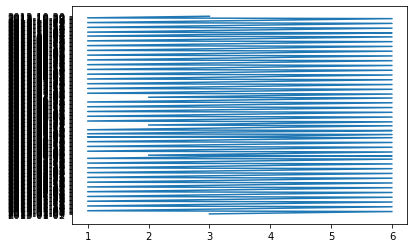

In [127]:
# Create figure and plot space
        
plt.plot( store_df.iloc[0:250,1],store_df.iloc[0:250,2])

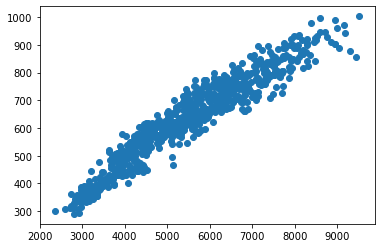

In [128]:
plt.scatter(store_df['Sales'],store_df['Customers'])

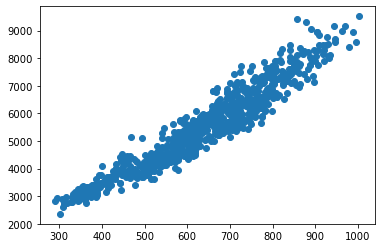

In [129]:
plt.scatter(store_df['Customers'], store_df['Sales'])

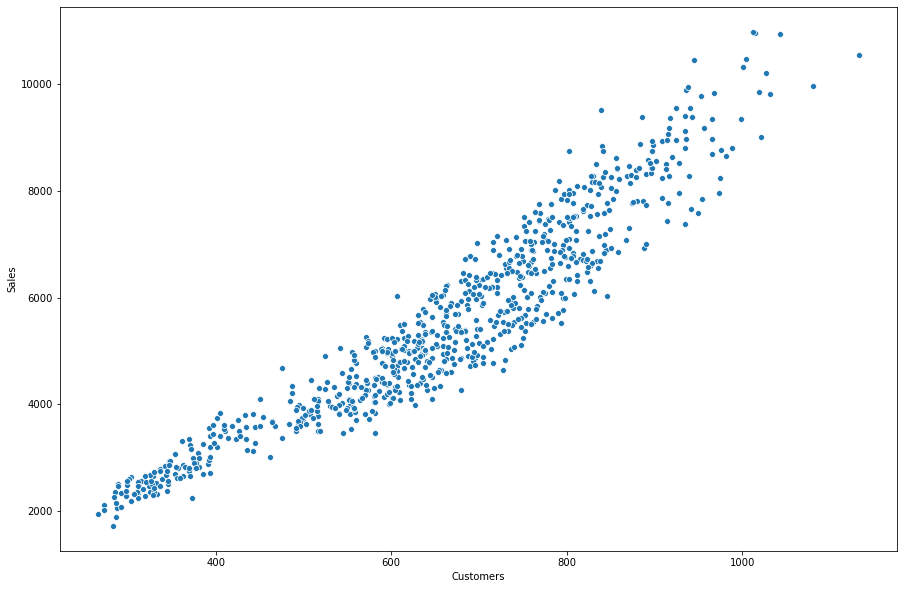

In [53]:
# visual inspection of sales(customers)
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales')

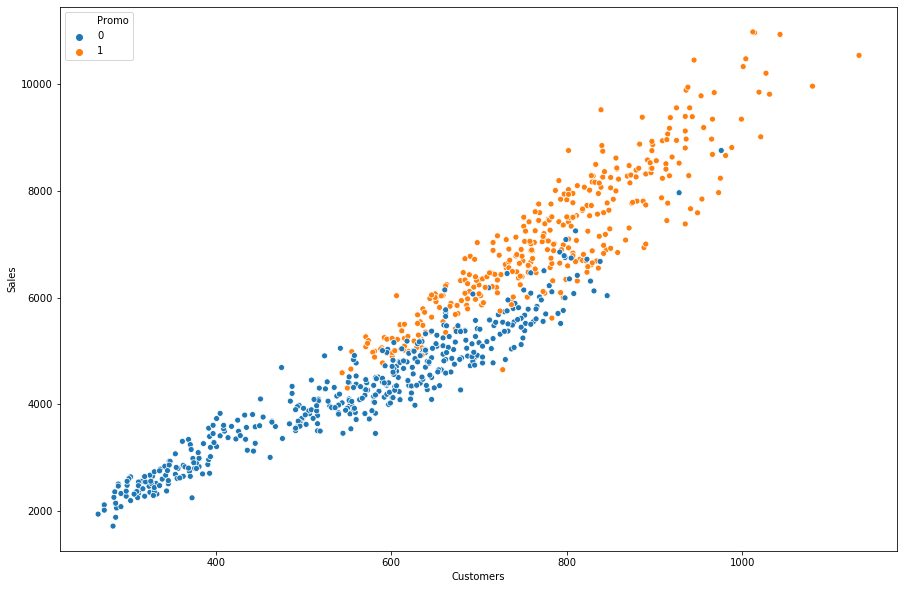

In [54]:
# visual inspection of sales(customers) and add promo influence
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales', hue = 'Promo')

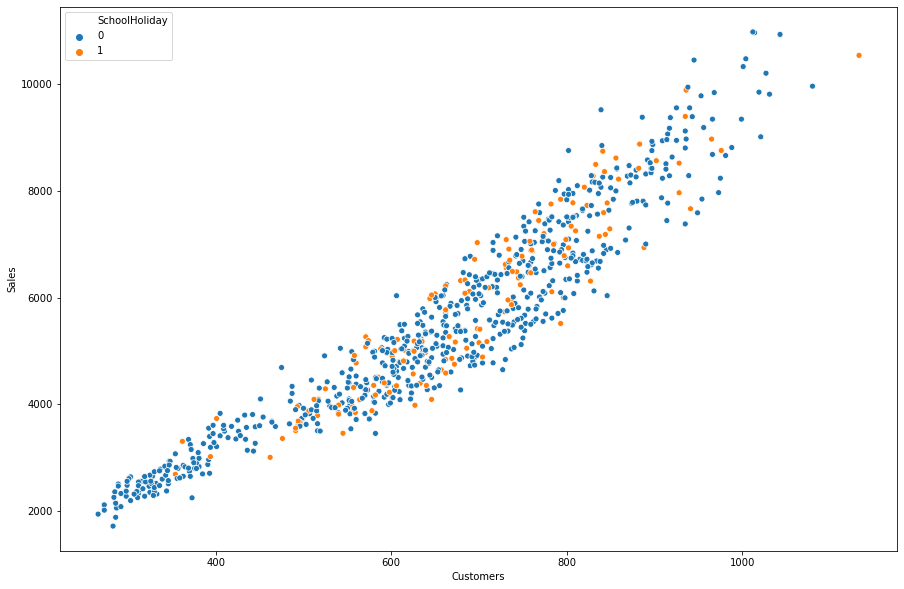

In [55]:
# check schoolholiday influence
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales', hue = 'SchoolHoliday')

- overall small effect

In [56]:
# months
store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)

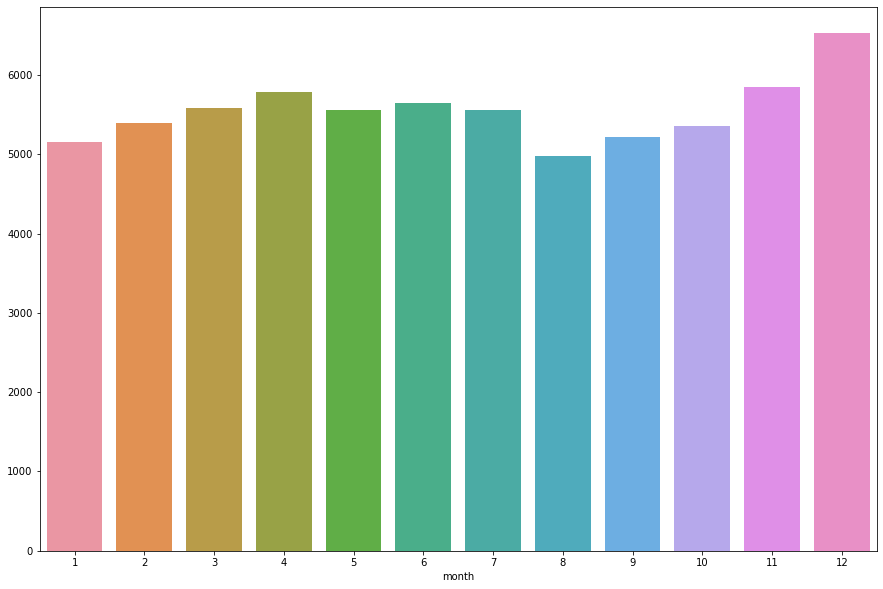

In [57]:
# check some month or weekday effects
result = store_df.groupby(['month']).mean().Sales
plt.figure(figsize = (15,10))
sns.barplot(x = result.index, y = result.values)

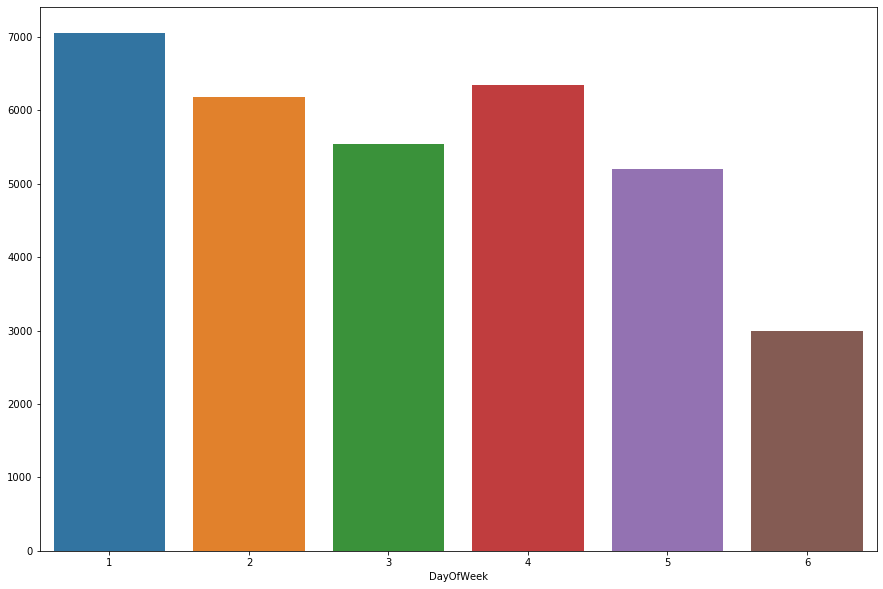

In [58]:
# check for weekdays
result = store_df.groupby(['DayOfWeek']).mean().Sales
plt.figure(figsize = (15,10))
sns.barplot(x = result.index, y = result.values)

In [59]:
# create dummies for weekdays and months
store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
store_dummies = return_dummies(store_dummies, 'month', pref = 'month')

In [60]:
store_dummies.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,day_1,day_2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,8,2013-01-02,5419,698,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,2013-01-03,4842,662,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,2013-01-04,4059,517,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,2013-01-05,2337,312,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,2013-01-07,7416,802,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# drop store, date, open, stateholiday
store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

In [62]:
# remove outliers
store_dummies = remove_outliers(store_dummies, 'Sales')

In [63]:
# decompose the timeseries
# find the frequency with the lowest error
f_sales = find_season(store_dummies, 'Sales')
f_customers = find_season(store_dummies, 'Customers')

In [64]:
result = decompose(store_dummies, 'Sales', freq = f_sales)

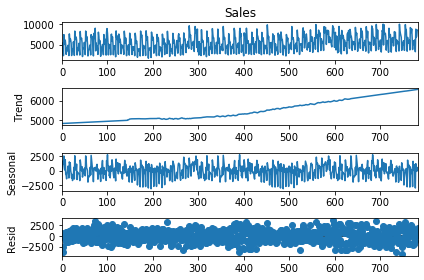

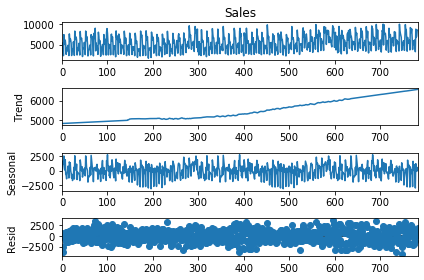

In [65]:
result.plot()

In [66]:
# save the trend and seasonality as features
store_dummies['Sales_trend'] = result.trend
store_dummies['Sales_season'] = result.seasonal

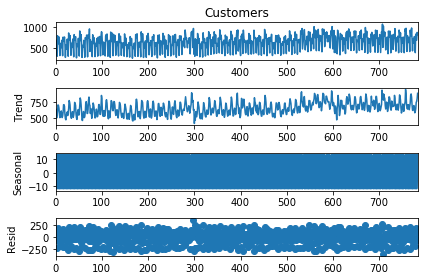

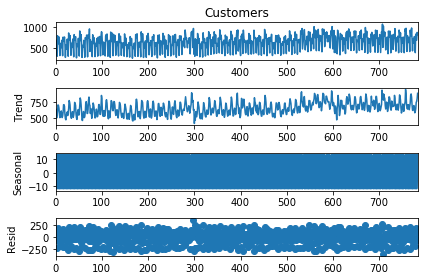

In [67]:
# same for customers
result = decompose(store_dummies, 'Customers', freq = f_customers)
result.plot()

In [68]:
store_dummies['Customers_trend'] = result.trend
store_dummies['Customers_season'] = result.seasonal

In [69]:
# check for stationary
# sales
test_stationary(store_dummies, 'Sales')

True

In [70]:
# customers
test_stationary(store_dummies, 'Customers')

True

In [71]:
# granger
granger_test(store_dummies, 'Customers', 'Sales', lags = 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=172.4309, p=0.0000  , df=1
likelihood ratio test: chi2=155.6905, p=0.0000  , df=1
parameter F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2
ssr based chi2 test:   chi2=337.3122, p=0.0000  , df=2
likelihood ratio test: chi2=279.9751, p=0.0000  , df=2
parameter F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3
ssr based chi2 test:   chi2=419.8104, p=0.0000  , df=3
likelihood ratio test: chi2=335.3185, p=0.0000  , df=3
parameter F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3


1.4078965478701753e-35

In [72]:
# granger
granger_test(store_dummies, 'Sales', 'Customers', lags = 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=107.4998, p=0.0000  , df=1
likelihood ratio test: chi2=100.6690, p=0.0000  , df=1
parameter F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1


1.3671389080044935e-23

In [73]:
# split in train and testset
test_size = 40 # 6 weeks á 6 days a week (sundays are off in germany...) are 36, with 40 days seems fair enough
train_df, test_df = store_dummies.iloc[:-1*test_size], store_dummies.iloc[-1*test_size:]

In [74]:
# define endogenouse and exogenous train variables
endog_train = train_df[['Sales','Customers']].astype('float32')
exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

# define endogenouse and exogenous test variables
endog_test = test_df[['Sales','Customers']].astype('float32')
exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

### VAR

In [75]:
# define VAR model
model = VAR(endog_train, exog = exog_train)
result = model.select_order(40)
result.summary()
minimum = result.aic
print(minimum)

6


In [76]:
# fit the model
result_fit = model.fit(maxlags = minimum)

In [77]:
predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = test_size, exog_future = exog_test.values), columns = ['Sales', 'Customers'])

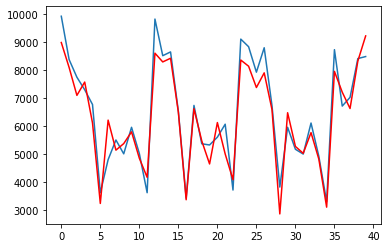

0.02294934204713303
0.07522611606952594


In [78]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)

# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

### VARMAX

In [79]:
# define a parametergrid to tune hyperparameters
param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}
pg = list(ParameterGrid(param_grid))

In [40]:
res = []
for a,b in enumerate(pg):
    # train a varmax model
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    print(f"Trying a: {a} p: {p} and q: {q} and tr: {tr}")
    max_model = VARMAX(endog_train, exog = exog_train, order = (p,q), trend = tr) 
    max_result = max_model.fit(disp = False)
    predicted_df = max_result.forecast(steps = test_size, exog = exog_test)
    MPE=np.mean((endog_test.Sales-predicted_df.Sales)/(endog_test.Sales))
    MAPE=np.mean(abs(endog_test.Sales-predicted_df.Sales)/(endog_test.Sales))
    res.append([a,MPE,MAPE])

Trying a: 0 p: 1 and q: 1 and tr: n


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:58

Trying a: 1 p: 1 and q: 1 and tr: c


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 2 p: 1 and q: 1 and tr: t


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 3 p: 1 and q: 1 and tr: ct


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 4 p: 1 and q: 2 and tr: n


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 5 p: 1 and q: 2 and tr: c


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 6 p: 1 and q: 2 and tr: t


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 7 p: 1 and q: 2 and tr: ct


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 8 p: 1 and q: 3 and tr: n


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 9 p: 1 and q: 3 and tr: c


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 10 p: 1 and q: 3 and tr: t


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 11 p: 1 and q: 3 and tr: ct


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 12 p: 2 and q: 1 and tr: n


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 13 p: 2 and q: 1 and tr: c


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 14 p: 2 and q: 1 and tr: t


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 15 p: 2 and q: 1 and tr: ct


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 16 p: 2 and q: 2 and tr: n


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 17 p: 2 and q: 2 and tr: c


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 18 p: 2 and q: 2 and tr: t


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 19 p: 2 and q: 2 and tr: ct


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 20 p: 2 and q: 3 and tr: n


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 21 p: 2 and q: 3 and tr: c


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 22 p: 2 and q: 3 and tr: t


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 23 p: 2 and q: 3 and tr: ct


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 24 p: 3 and q: 1 and tr: n


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 25 p: 3 and q: 1 and tr: c


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 26 p: 3 and q: 1 and tr: t


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 27 p: 3 and q: 1 and tr: ct


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 28 p: 3 and q: 2 and tr: n


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 29 p: 3 and q: 2 and tr: c


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:1

Trying a: 30 p: 3 and q: 2 and tr: t


KeyboardInterrupt: 

In [80]:
mape = [abs(res[i][2]) for i in range(len(res))]

In [81]:
pg[np.array(mape).argmin()]

{'p': 3, 'q': 1, 'tr': 'c'}

In [82]:
# train a varmax model
max_model = VARMAX(endog_train, exog = exog_train, order = (3,3), trend = 'n') 
max_result = max_model.fit(disp = False)

print(max_result.summary())
print(max_result.params)

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  736
Model:                        VARMAX(3,3)   Log Likelihood               -9961.510
Date:                    Mon, 04 Jan 2021   AIC                          20073.020
Time:                            22:51:05   BIC                          20418.112
Sample:                                 0   HQIC                         20206.108
                                    - 736                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              251.94, 192.87   Jarque-Bera (JB):          3.90, 65.05
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.14, 0.00
Heteroskedasticity (H):         1.37, 1.79   Skew:                       0.18, 0.27
Prob(H) (two-sided):            0.01, 0.00   Kurtosis:                   2.97, 4.35


In [83]:
# forecast
predicted_df = max_result.forecast(steps = 40, exog = exog_test)

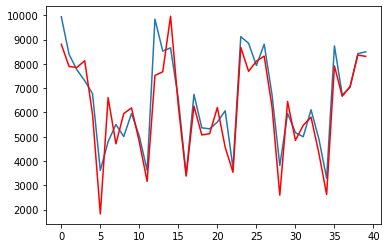

0.049007886494841287
0.10857942921088748


In [84]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)
pred = pred[pred.ActualSales != 0]


# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

VAR slightly better performed than VARMAX

In [85]:
result = granger_test(store_dummies, 'Customers', 'Sales', lags = 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=172.4309, p=0.0000  , df=1
likelihood ratio test: chi2=155.6905, p=0.0000  , df=1
parameter F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2
ssr based chi2 test:   chi2=337.3122, p=0.0000  , df=2
likelihood ratio test: chi2=279.9751, p=0.0000  , df=2
parameter F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3
ssr based chi2 test:   chi2=419.8104, p=0.0000  , df=3
likelihood ratio test: chi2=335.3185, p=0.0000  , df=3
parameter F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3


In [86]:
result = grangercausalitytests(store_dummies[['Customers', 'Sales']], 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=107.4998, p=0.0000  , df=1
likelihood ratio test: chi2=100.6690, p=0.0000  , df=1
parameter F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=138.6125, p=0.0000  , df_denom=769, df_num=2
ssr based chi2 test:   chi2=279.0276, p=0.0000  , df=2
likelihood ratio test: chi2=238.2781, p=0.0000  , df=2
parameter F test:         F=138.6125, p=0.0000  , df_denom=769, df_num=2


# both non-stationary timeseries VAR model

In [87]:
# select store
store_df = return_storedata(data_df, 30)

In [88]:
# reverse order
store_df = store_df.iloc[::-1]
# remove outliers in sales, 99. percentile
store_df = remove_outliers(store_df, 'Sales')
# reset index
store_df = store_df.reset_index(drop = True)

In [89]:
# extract months
store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)

In [90]:
# create dummies for weekdays and months
store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
store_dummies = return_dummies(store_dummies, 'month', pref = 'month')

In [91]:
#check stationary
#sales
print(f"Sales series is stationary? {test_stationary(store_dummies, 'Sales')}")
print(f"Customer series is stationary? {test_stationary(store_dummies, 'Customers')}")

Sales series is stationary? False
Customer series is stationary? False


In [92]:
store_dummies.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,day_1,day_2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,30,2013-01-02,5683,943,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,2013-01-03,6219,987,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,2013-01-04,5035,803,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,2013-01-05,5643,898,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,2013-01-07,9174,1187,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

In [94]:
# decompose the timeseries
# find the frequency with the lowest error
f_sales = find_season(store_dummies, 'Sales')
f_customers = find_season(store_dummies, 'Customers')

In [95]:
result = decompose(store_dummies, 'Sales', freq = f_sales)
# save the trend and seasonality as features
store_dummies['Sales_trend'] = result.trend
store_dummies['Sales_season'] = result.seasonal

In [96]:
result = decompose(store_dummies, 'Customers', freq = f_customers)
store_dummies['Customers_trend'] = result.trend
store_dummies['Customers_season'] = result.seasonal

In [99]:
#train-test-split
lag = 40
train_df, test_df = store_dummies.iloc[:-1*lag], store_dummies.iloc[-1*lag:]

In [101]:
# define endogenouse and exogenous test variables
endog_train = train_df[['Sales','Customers']].astype('float32')
exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

In [102]:
endog_diff = endog_train.diff().dropna().reset_index(drop = True)
#exog_diff = exog_train.diff().dropna().reset_index(drop = True)
exog_diff = exog_train.iloc[1:].reset_index(drop = True)

In [103]:
# define endogenouse and exogenous test variables
endog_test = test_df[['Sales','Customers']].astype('float32')
exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

In [104]:
# define VAR model
model = VAR(endog_diff, exog = exog_diff)
result = model.select_order(f_sales)
result.summary()
minimum = result.aic
minimum

26

In [105]:
# fit the model
result_fit = model.fit(maxlags = minimum)

In [106]:
#predicted_df = pd.DataFrame(result_fit.forecast(y = endog_train[-40:].values, steps = 40, exog_future = exog_test.values), columns = ['Sales', 'Customers'])
predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = 40, exog_future = exog_test.values), columns = ['Sales', 'Customers'])

In [107]:
predicted_df['Sales'] = predicted_df['Sales'].cumsum()+train_df['Sales'].values[-1]

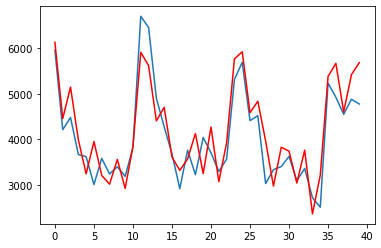

-0.04374199701691791
0.10868261034219948


In [108]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)

# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

## One non-stationary time series

In [109]:
# select store
store_df = return_storedata(data_df, 6)
# reverse order
store_df = store_df.iloc[::-1]
# remove outliers in sales, 99. percentile
store_df = remove_outliers(store_df, 'Sales')
# reset index
store_df = store_df.reset_index(drop = True)
# extract months
store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)
# create dummies for weekdays and months
store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
store_dummies = return_dummies(store_dummies, 'month', pref = 'month')

In [110]:
#check stationary
#sales
print(f"Sales series is stationary? {test_stationary(store_dummies, 'Sales')}")
print(f"Customer series is stationary? {test_stationary(store_dummies, 'Customers')}")

Sales series is stationary? True
Customer series is stationary? False


In [111]:
#drop not useful features
store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

# decompose the timeseries
# find the frequency with the lowest error
f_sales = find_season(store_dummies, 'Sales')
f_customers = find_season(store_dummies, 'Customers')

result = decompose(store_dummies, 'Sales', freq = f_sales)
# save the trend and seasonality as features
store_dummies['Sales_trend'] = result.trend
store_dummies['Sales_season'] = result.seasonal

result = decompose(store_dummies, 'Customers', freq = f_customers)
store_dummies['Customers_trend'] = result.trend
store_dummies['Customers_season'] = result.seasonal

#train-test-split
lag = 40
train_df, test_df = store_dummies.iloc[:-1*lag], store_dummies.iloc[-1*lag:]

In [112]:
# define endogenouse and exogenous train variables
endog_train = train_df[['Sales','Customers']].astype('float32')
exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

endog_diff = endog_train.diff().dropna().reset_index(drop = True)
exog_diff = exog_train.iloc[1:].reset_index(drop = True)

# define endogenouse and exogenous test variables
endog_test = test_df[['Sales','Customers']].astype('float32')
exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

In [113]:
# define VAR model
model = VAR(endog_diff, exog = exog_diff)
result = model.select_order(f_sales)
result.summary()
minimum = result.aic
minimum

28

In [114]:
# fit the model
result_fit = model.fit(maxlags = minimum)

In [115]:
predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = 40, exog_future = exog_test.values), columns = ['Sales', 'Customers'])

In [116]:
# de-difference
predicted_df['Sales'] = predicted_df['Sales'].cumsum()+train_df['Sales'].values[-1]

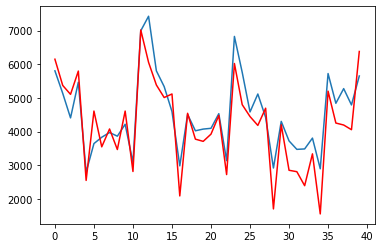

0.07802309005245002
0.12924992515397496


In [117]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)

# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

## Pipeline

In [118]:
def rossmann_prediction(data_df, store_id, days = 40, lags_max = 40, plotting = False, max_f = 190):

    # select store
    store_df = return_storedata(data_df, store_id)
    
    # reverse order
    store_df = store_df.iloc[::-1]

    # remove outliers in sales, 99. percentile
    store_df = remove_outliers(store_df, 'Sales')
    
    # reset index
    store_df = store_df.reset_index(drop = True)

    # extract months
    store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)

    # create dummies for weekdays and months
    store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
    store_dummies = return_dummies(store_dummies, 'month', pref = 'month')
    
    #check stationary
    sales_stationary = test_stationary(store_dummies, 'Sales')
    customers_stationary = test_stationary(store_dummies, 'Customers')
    stationary = sales_stationary and customers_stationary
    
    #drop not useful features
    store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

    # decompose the timeseries
    # find the frequency with the lowest error sales
    f_sales = find_season(store_dummies, 'Sales', fmax = max_f)
    f_customers = find_season(store_dummies, 'Customers', fmax = max_f)
    result = decompose(store_dummies, 'Sales', freq = f_sales)
    # save the trend and seasonality as features
    store_dummies['Sales_trend'] = result.trend
    store_dummies['Sales_season'] = result.seasonal

    # find the frequency with the lowest error customers
    result = decompose(store_dummies, 'Customers', freq = f_customers)
    # save the trend and seasonality as features
    store_dummies['Customers_trend'] = result.trend
    store_dummies['Customers_season'] = result.seasonal

    #train-test-split
    train_df, test_df = store_dummies.iloc[:-1*days], store_dummies.iloc[-1*days:]
    
    # define endogenouse and exogenous train variables
    endog_train = train_df[['Sales','Customers']].astype('float32')
    exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

    # difference the timeseries if sales or customers timeseries isn't stationary
    if not stationary:
        endog_train = endog_train.diff().dropna().reset_index(drop = True)
        exog_train = exog_train.iloc[1:].reset_index(drop = True)
        
    # define endogenouse and exogenous test variables
    endog_test = test_df[['Sales','Customers']].astype('float32')
    exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')
    
    # define VAR model
    model = VAR(endog_train, exog = exog_train)
    result = model.select_order(lags_max)
    result.summary()
    minimum = result.aic
    
    # fit the model
    result_fit = model.fit(maxlags = minimum)
    
    # forecast the model
    predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = days, exog_future = exog_test.values), columns = ['Sales', 'Customers'])
    
    # de-difference if necessary
    if not stationary:
        predicted_df['Sales'] = predicted_df['Sales'].cumsum()+train_df['Sales'].values[-1]
    
    # benchmark
    actual=endog_test[["Sales"]]
    actual.columns=['ActualSales']
    actual=actual.reset_index(drop=True)
    predicted=predicted_df[['Sales']]
    predicted=predicted.reset_index(drop=True)
    pred=pd.merge(actual, predicted, right_index=True, left_index=True)

    # plot
    fig = plt.figure(figsize = (10,8))
    plt.title(f"{days} business days sales forecasting for Rossmann store ID: {store_id}", fontsize = 16)
    plt.xlabel("days", fontsize = 14)
    plt.ylabel("sales in euro", fontsize = 14)
    plt.plot(actual, label = "Groundtruth")
    plt.plot(predicted, color='red', label = "Forecast")
    plt.legend()
    plt.savefig(f"./output/store_{store_id}.png")
    if plotting:
        plt.show()
    plt.close(fig)
    
    pred.to_csv(f"./output/store_{store_id}.csv")
    MPE=calculate_mpe(pred.ActualSales,pred.Sales)
    #print(MPE)

    MAPE=calculate_mape(pred.ActualSales,pred.Sales)
    #print(MAPE)
    return [MPE,MAPE,stationary,minimum]

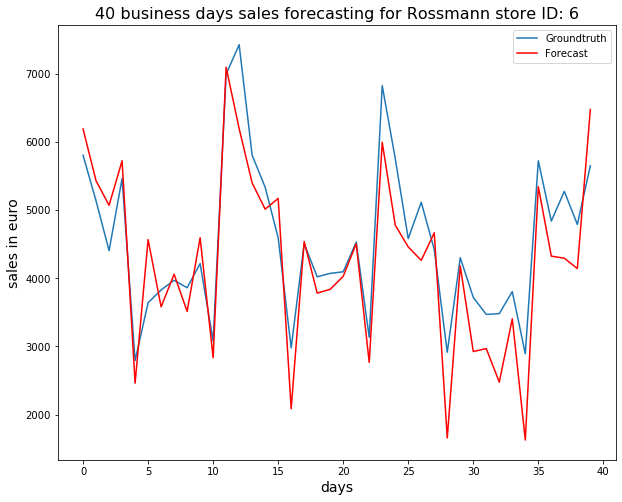

[0.06983059972266854, 0.12169644471805066, False, 31]

In [119]:
rossmann_prediction(data_df, 6, days = 40, plotting = True)

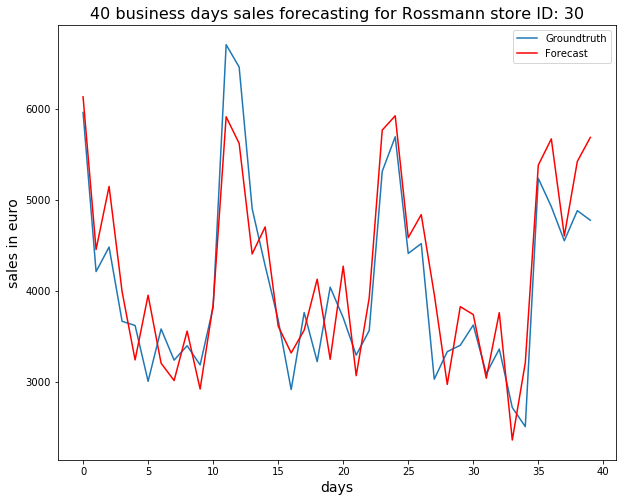

[-0.04374199701691791, 0.10868261034219948, False, 26]

In [120]:
rossmann_prediction(data_df, 30, days = 40, plotting = True)

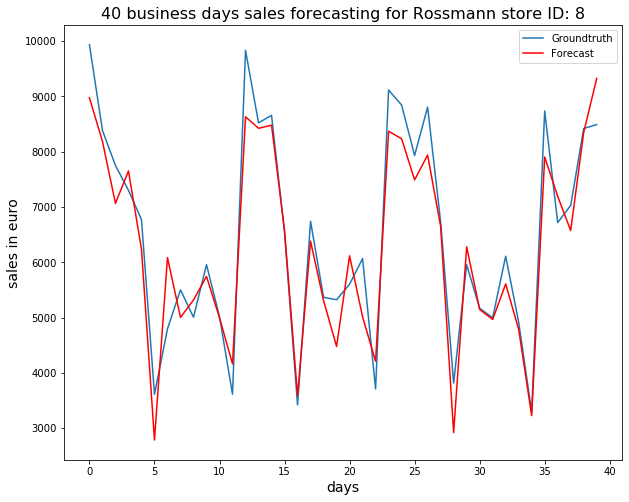

In [121]:
results = rossmann_prediction(data_df, 8, days = 40, plotting = True)

In [123]:
MPEs = []
MAPEs = []
Stationaries = []
AICs = []
for i in range(1,1116):
    results = rossmann_prediction(data_df, i, days = 40)
    MPEs.append(results[0])
    MAPEs.append(results[1])
    Stationaries.append(results[2])
    AICs.append(results[3])
    print(f"Store ID: {i}\tStationary: {results[2]}\tMPE: {results[0]:.4f}\tMAPE: {results[1]:.4f}\tAIC: {results[3]}")

Store ID: 1	Stationary: True	MPE: 0.0249	MAPE: 0.0868	AIC: 15
Store ID: 2	Stationary: True	MPE: -0.0113	MAPE: 0.1012	AIC: 12
Store ID: 3	Stationary: True	MPE: -0.0303	MAPE: 0.0466	AIC: 7
Store ID: 4	Stationary: True	MPE: 0.0557	MAPE: 0.0811	AIC: 14
Store ID: 5	Stationary: True	MPE: -0.0063	MAPE: 0.0628	AIC: 6
Store ID: 6	Stationary: False	MPE: 0.0698	MAPE: 0.1217	AIC: 31
Store ID: 7	Stationary: True	MPE: -0.0232	MAPE: 0.0712	AIC: 6
Store ID: 8	Stationary: True	MPE: 0.0255	MAPE: 0.0774	AIC: 8
Store ID: 9	Stationary: True	MPE: -0.0096	MAPE: 0.0674	AIC: 6
Store ID: 10	Stationary: True	MPE: -0.0153	MAPE: 0.0854	AIC: 12
Store ID: 11	Stationary: True	MPE: 0.0302	MAPE: 0.1055	AIC: 13
Store ID: 12	Stationary: True	MPE: 0.0484	MAPE: 0.0845	AIC: 8
Store ID: 13	Stationary: True	MPE: -0.0365	MAPE: 0.1169	AIC: 3
Store ID: 14	Stationary: True	MPE: 0.0228	MAPE: 0.0600	AIC: 12
Store ID: 15	Stationary: True	MPE: 0.0176	MAPE: 0.0931	AIC: 7
Store ID: 16	Stationary: True	MPE: -0.0270	MAPE: 0.0772	AIC: 6
S

Store ID: 131	Stationary: False	MPE: -0.1948	MAPE: 0.2049	AIC: 23
Store ID: 132	Stationary: False	MPE: -0.0164	MAPE: 0.0688	AIC: 24
Store ID: 133	Stationary: True	MPE: -0.0049	MAPE: 0.0720	AIC: 21
Store ID: 134	Stationary: True	MPE: -0.0233	MAPE: 0.0639	AIC: 6
Store ID: 135	Stationary: True	MPE: -0.0277	MAPE: 0.1128	AIC: 7
Store ID: 136	Stationary: False	MPE: -0.0857	MAPE: 0.1240	AIC: 25
Store ID: 137	Stationary: True	MPE: -0.0134	MAPE: 0.0799	AIC: 4
Store ID: 138	Stationary: True	MPE: -0.0142	MAPE: 0.0651	AIC: 19
Store ID: 139	Stationary: True	MPE: -0.0660	MAPE: 0.1203	AIC: 4
Store ID: 140	Stationary: True	MPE: -0.0061	MAPE: 0.0707	AIC: 3
Store ID: 141	Stationary: True	MPE: 0.0178	MAPE: 0.0707	AIC: 15
Store ID: 142	Stationary: True	MPE: -0.0276	MAPE: 0.0648	AIC: 6
Store ID: 143	Stationary: True	MPE: -0.0425	MAPE: 0.1062	AIC: 18
Store ID: 144	Stationary: True	MPE: -0.0016	MAPE: 0.0425	AIC: 12
Store ID: 145	Stationary: False	MPE: -0.0968	MAPE: 0.1223	AIC: 25
Store ID: 146	Stationary: Tr

Store ID: 259	Stationary: True	MPE: -0.0072	MAPE: 0.0421	AIC: 8
Store ID: 260	Stationary: True	MPE: -0.0206	MAPE: 0.0621	AIC: 8
Store ID: 261	Stationary: True	MPE: -0.0303	MAPE: 0.0804	AIC: 13
Store ID: 262	Stationary: True	MPE: -0.0082	MAPE: 0.0386	AIC: 15
Store ID: 263	Stationary: False	MPE: 0.0231	MAPE: 0.0670	AIC: 11
Store ID: 264	Stationary: True	MPE: -0.0219	MAPE: 0.0947	AIC: 7
Store ID: 265	Stationary: True	MPE: -0.0487	MAPE: 0.1084	AIC: 6
Store ID: 266	Stationary: True	MPE: 0.0072	MAPE: 0.0729	AIC: 3
Store ID: 267	Stationary: True	MPE: 0.1471	MAPE: 0.1666	AIC: 13
Store ID: 268	Stationary: True	MPE: -0.0244	MAPE: 0.1149	AIC: 16
Store ID: 269	Stationary: True	MPE: 0.0047	MAPE: 0.1186	AIC: 6
Store ID: 270	Stationary: True	MPE: -0.0044	MAPE: 0.0573	AIC: 18
Store ID: 271	Stationary: True	MPE: -0.0659	MAPE: 0.1248	AIC: 7
Store ID: 272	Stationary: True	MPE: -0.0278	MAPE: 0.0921	AIC: 7
Store ID: 273	Stationary: True	MPE: 0.0363	MAPE: 0.0764	AIC: 14
Store ID: 274	Stationary: False	MPE: 

KeyboardInterrupt: 

In [124]:
print(f"Average MPE: {np.mean(MPEs):.4f}\nAverage MAPE: {np.mean(MAPEs):.4f}")

Average MPE: -0.0081
Average MAPE: 0.0882
